
# Deep Learning Experiments on CIFAR-10


*   Name - Gaurav Sharan
*   Registration Number - 20MIA1081


---



In [1]:
!pip install torch torchvision wandb



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # For activation functions
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import wandb
import time
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Log in to Weights & Biases
wandb.login()


Using device: cuda


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gauravengineer85 (gauravengineer85-vellore-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
class BasicBlock(nn.Module):
    expansion = 1  # For basic block the expansion factor is 1

    def __init__(self, in_planes, planes, stride=1):
        """
        A basic residual block for ResNet‑32.
        Args:
          in_planes: Number of input channels.
          planes: Number of output channels.
          stride: Stride for the first convolution.
        """
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        # Define the shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet32(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        """
        Constructs a ResNet‑32 model for CIFAR‑10.
        Args:
          block: Block type (BasicBlock).
          num_blocks: A list specifying how many blocks each layer should have (for ResNet-32, this would be [5, 5, 5]).
          num_classes: Number of output classes (10 for CIFAR‑10).
        """
        super(ResNet32, self).__init__()
        self.in_planes = 16

        # Initial convolution layer (3×3 conv for CIFAR‑10)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        # Creating three layers (groups) of residual blocks
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        # Global average pooling and final fully connected layer
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        """
        Creates one group (layer) of residual blocks.
        """
        strides = [stride] + [1]*(num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # Global average pooling over spatial dimensions
        out = F.avg_pool2d(out, out.size(3))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def get_resnet32_for_cifar10():
    """
    Instantiates a ResNet‑32 model for CIFAR‑10.
    For ResNet‑32, we use 5 residual blocks per layer: [5, 5, 5].
    Returns:
      model (nn.Module): A ResNet‑32 model.
    """
    return ResNet32(BasicBlock, [5, 5, 5], num_classes=10)


In [4]:
def train_one_epoch(model, optimizer, criterion, train_loader, device):
    """
    Trains the model for one epoch.

    Args:
      model (nn.Module): Model to train.
      optimizer: Optimizer.
      criterion: Loss function.
      train_loader (DataLoader): Training data loader.
      device: CPU or GPU.

    Returns:
      epoch_loss (float): Average training loss.
      epoch_acc (float): Training accuracy.
    """
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, criterion, loader, device):
    """
    Evaluates the model on a validation/test set.

    Args:
      model (nn.Module): Model to evaluate.
      criterion: Loss function.
      loader (DataLoader): Validation/test data loader.
      device: CPU or GPU.

    Returns:
      epoch_loss (float): Average loss.
      epoch_acc (float): Accuracy.
    """
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [5]:
def run_experiment(config=None):
    """
    Runs a single experiment with the given hyperparameters.
    - Each experiment gets logged as a separate run on W&B.
    - Checkpoints are saved at the end of each epoch with unique filenames and uploaded.
    - Optionally, a MultiStepLR scheduler can be used if specified.

    Args:
      config (dict): A dictionary containing the hyperparameters for the experiment.

    Returns:
      model (nn.Module): The trained model after the experiment.
      test_loader (DataLoader): The DataLoader for the test dataset, ready for evaluation.
    """
    with wandb.init(project="-Deep-Learning-Experiments-on-CIFAR-10", config=config) as run:
        config = wandb.config

        # Data transformations for training and testing
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
        ])

        # Download CIFAR-10 dataset
        train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
        test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

        # Create a train/validation split (80% train, 20% validation)
        num_train = int(0.8 * len(train_dataset))
        num_val = len(train_dataset) - num_train
        train_subset, val_subset = torch.utils.data.random_split(train_dataset, [num_train, num_val])

        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=config.batch_size, shuffle=True, num_workers=2)
        val_loader   = torch.utils.data.DataLoader(val_subset, batch_size=config.batch_size, shuffle=False, num_workers=2)
        test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

        # Initialize the ResNet-32 model for CIFAR-10
        model = get_resnet32_for_cifar10().to(device)

        # Define the loss function
        criterion = nn.CrossEntropyLoss()

        # Select the optimizer based on configuration
        if config.optimizer.lower() == "sgd":
            optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9, weight_decay=5e-4)
        elif config.optimizer.lower() == "adam":
            optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=5e-4)
        else:
            raise ValueError("Unsupported optimizer type. Please choose 'sgd' or 'adam'.")

        # Optionally, set up a learning rate scheduler
        scheduler = None
        if hasattr(config, "use_scheduler") and config.use_scheduler:
            # Decay learning rate at 50% and 75% of total epochs
            milestones = [int(config.epochs * 0.5), int(config.epochs * 0.75)]
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

        best_val_acc = 0.0  # To track the best validation accuracy

        # Training loop for the specified number of epochs
        for epoch in range(config.epochs):
            train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device)
            val_loss, val_acc = validate(model, criterion, val_loader, device)

            # Log metrics to W&B for the current epoch
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "learning_rate": optimizer.param_groups[0]['lr'],
                "optimizer": config.optimizer
            })

            print(f"Epoch [{epoch+1}/{config.epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            # Save every epoch's checkpoint with a unique filename
            checkpoint_filename = f"{wandb.run.id}_epoch_{epoch+1}_{int(time.time())}.pth"
            torch.save(model.state_dict(), checkpoint_filename)
            wandb.save(checkpoint_filename)

            # Optionally, save the best model checkpoint separately if validation accuracy improves
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_checkpoint = f"{wandb.run.id}_best_epoch_{epoch+1}_{int(time.time())}.pth"
                torch.save(model.state_dict(), best_checkpoint)
                wandb.save(best_checkpoint)

            # Step the learning rate scheduler, if used
            if scheduler is not None:
                scheduler.step()

        # After training, evaluate the model on the test set
        test_loss, test_acc = validate(model, criterion, test_loader, device)
        wandb.log({"test_loss": test_loss, "test_acc": test_acc})
        print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

        # Return the trained model and test_loader for further analysis if needed
        return model, test_loader


In [6]:
# Define six hyperparameter configurations
experiment_configs = [

    {"epochs": 10, "batch_size": 128, "learning_rate": 0.001, "optimizer": "adam"},
    {"epochs": 10, "batch_size": 128, "learning_rate": 0.5, "optimizer": "adam"},
    {"epochs": 12, "batch_size": 128, "learning_rate": 0.0001, "optimizer": "adam"},
    {"epochs": 10, "batch_size": 128, "learning_rate": 0.001, "optimizer": "sgd"},
    {"epochs": 10, "batch_size": 128, "learning_rate": 0.0005, "optimizer": "sgd"},
    {"epochs": 85, "batch_size": 128, "learning_rate": 0.1, "optimizer": "sgd", "use_scheduler": True}
]

# Run each experiment sequentially
for config in experiment_configs:
    print("\nStarting experiment with configuration:")
    print(config)
    run_experiment(config)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.



Starting experiment with configuration:
{'epochs': 10, 'batch_size': 128, 'learning_rate': 0.001, 'optimizer': 'adam'}


100%|██████████| 170M/170M [00:03<00:00, 42.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/10] | Train Loss: 1.5508 | Train Acc: 0.4279 | Val Loss: 1.5323 | Val Acc: 0.4654
Epoch [2/10] | Train Loss: 1.1368 | Train Acc: 0.5928 | Val Loss: 1.1430 | Val Acc: 0.5938
Epoch [3/10] | Train Loss: 0.9524 | Train Acc: 0.6605 | Val Loss: 1.5651 | Val Acc: 0.5249
Epoch [4/10] | Train Loss: 0.8242 | Train Acc: 0.7073 | Val Loss: 0.8743 | Val Acc: 0.6883
Epoch [5/10] | Train Loss: 0.7439 | Train Acc: 0.7399 | Val Loss: 0.7422 | Val Acc: 0.7434
Epoch [6/10] | Train Loss: 0.6808 | Train Acc: 0.7652 | Val Loss: 0.7802 | Val Acc: 0.7342
Epoch [7/10] | Train Loss: 0.6374 | Train Acc: 0.7816 | Val Loss: 0.6525 | Val Acc: 0.7742
Epoch [8/10] | Train Loss: 0.6002 | Train Acc: 0.7932 | Val Loss: 0.7998 | Val Acc: 0.7319
Epoch [9/10] | Train Loss: 0.5672 | Train Acc: 0.8051 | Val Loss: 0.7070 | Val Acc: 0.7524
Epoch [10/10] | Train Loss: 0.5413 | Train Acc: 0.8140 | Val Loss: 0.6838 | Val Acc: 0.7740


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▂▆▇▇█▇██
val_loss,█▅█▃▂▂▁▂▁▁
epoch,10
learning_rate,0.001
optimizer,adam



Starting experiment with configuration:
{'epochs': 10, 'batch_size': 128, 'learning_rate': 0.5, 'optimizer': 'adam'}


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10] | Train Loss: 2.5328 | Train Acc: 0.1548 | Val Loss: 5.0554 | Val Acc: 0.1093
Epoch [2/10] | Train Loss: 2.3884 | Train Acc: 0.1242 | Val Loss: 784.5759 | Val Acc: 0.0969
Epoch [3/10] | Train Loss: 2.5197 | Train Acc: 0.1028 | Val Loss: 5.6845 | Val Acc: 0.1016
Epoch [4/10] | Train Loss: 2.6137 | Train Acc: 0.1056 | Val Loss: 473.1868 | Val Acc: 0.0982
Epoch [5/10] | Train Loss: 2.4229 | Train Acc: 0.1092 | Val Loss: 3.1442 | Val Acc: 0.0997
Epoch [6/10] | Train Loss: 2.3845 | Train Acc: 0.1018 | Val Loss: 5668.8476 | Val Acc: 0.1016
Epoch [7/10] | Train Loss: 2.3593 | Train Acc: 0.1192 | Val Loss: 2.3155 | Val Acc: 0.0977
Epoch [8/10] | Train Loss: 2.4367 | Train Acc: 0.1110 | Val Loss: 58.4995 | Val Acc: 0.0988
Epoch [9/10] | Train Loss: 2.4514 | Train Acc: 0.1056 | Val Loss: 3.5730 | Val Acc: 0.1071
Epoch [10/10] | Train Loss: 2.5021 | Train Acc: 0.1045 | Val Loss: 8034.9673 | Val Acc: 0.0997
Te

epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,█▄▁▂▂▁▃▂▁▁
train_loss,▆▂▅█▃▂▁▃▄▅
val_acc,█▁▄▂▃▄▁▂▇▃
val_loss,▁▂▁▁▁▆▁▁▁█
epoch,10
learning_rate,0.5
optimizer,adam



Starting experiment with configuration:
{'epochs': 12, 'batch_size': 128, 'learning_rate': 0.0001, 'optimizer': 'adam'}


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/12] | Train Loss: 1.7752 | Train Acc: 0.3370 | Val Loss: 1.5943 | Val Acc: 0.4186
Epoch [2/12] | Train Loss: 1.4429 | Train Acc: 0.4693 | Val Loss: 1.3971 | Val Acc: 0.4893
Epoch [3/12] | Train Loss: 1.3035 | Train Acc: 0.5298 | Val Loss: 1.3606 | Val Acc: 0.5093
Epoch [4/12] | Train Loss: 1.1968 | Train Acc: 0.5670 | Val Loss: 1.1728 | Val Acc: 0.5768
Epoch [5/12] | Train Loss: 1.1040 | Train Acc: 0.6046 | Val Loss: 1.1120 | Val Acc: 0.6043
Epoch [6/12] | Train Loss: 1.0371 | Train Acc: 0.6299 | Val Loss: 1.0386 | Val Acc: 0.6313
Epoch [7/12] | Train Loss: 0.9802 | Train Acc: 0.6536 | Val Loss: 0.9859 | Val Acc: 0.6485
Epoch [8/12] | Train Loss: 0.9303 | Train Acc: 0.6707 | Val Loss: 0.9353 | Val Acc: 0.6651
Epoch [9/12] | Train Loss: 0.8852 | Train Acc: 0.6897 | Val Loss: 0.9361 | Val Acc: 0.6722
Epoch [10/12] | Train Loss: 0.8420 | Train Acc: 0.7038 | Val Loss: 0.8800 | Val Acc: 0.6864
Epoch [11/12]

epoch,▁▂▂▃▄▄▅▅▆▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▃▄▅▆▆▇▇▇███
train_loss,█▆▅▄▃▃▂▂▂▂▁▁
val_acc,▁▃▃▅▅▆▆▇▇▇▇█
val_loss,█▆▆▄▄▃▃▂▂▂▂▁
epoch,12
learning_rate,0.0001
optimizer,adam



Starting experiment with configuration:
{'epochs': 10, 'batch_size': 128, 'learning_rate': 0.001, 'optimizer': 'sgd'}


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10] | Train Loss: 1.8385 | Train Acc: 0.3063 | Val Loss: 1.6675 | Val Acc: 0.3742
Epoch [2/10] | Train Loss: 1.5326 | Train Acc: 0.4299 | Val Loss: 1.5137 | Val Acc: 0.4442
Epoch [3/10] | Train Loss: 1.3640 | Train Acc: 0.4999 | Val Loss: 1.3207 | Val Acc: 0.5189
Epoch [4/10] | Train Loss: 1.2282 | Train Acc: 0.5543 | Val Loss: 1.2100 | Val Acc: 0.5633
Epoch [5/10] | Train Loss: 1.1227 | Train Acc: 0.5918 | Val Loss: 1.1520 | Val Acc: 0.5916
Epoch [6/10] | Train Loss: 1.0515 | Train Acc: 0.6204 | Val Loss: 1.0147 | Val Acc: 0.6336
Epoch [7/10] | Train Loss: 0.9866 | Train Acc: 0.6454 | Val Loss: 0.9891 | Val Acc: 0.6448
Epoch [8/10] | Train Loss: 0.9312 | Train Acc: 0.6681 | Val Loss: 1.0441 | Val Acc: 0.6327
Epoch [9/10] | Train Loss: 0.8886 | Train Acc: 0.6804 | Val Loss: 0.8978 | Val Acc: 0.6795
Epoch [10/10] | Train Loss: 0.8465 | Train Acc: 0.6964 | Val Loss: 0.8696 | Val Acc: 0.6900
Test Loss: 0.

epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▃▄▅▆▇▇▇██
val_loss,█▇▅▄▃▂▂▃▁▁
epoch,10
learning_rate,0.001
optimizer,sgd



Starting experiment with configuration:
{'epochs': 10, 'batch_size': 128, 'learning_rate': 0.0005, 'optimizer': 'sgd'}


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10] | Train Loss: 1.9991 | Train Acc: 0.2462 | Val Loss: 1.7891 | Val Acc: 0.3264
Epoch [2/10] | Train Loss: 1.6866 | Train Acc: 0.3597 | Val Loss: 1.6005 | Val Acc: 0.3953
Epoch [3/10] | Train Loss: 1.5536 | Train Acc: 0.4183 | Val Loss: 1.4921 | Val Acc: 0.4473
Epoch [4/10] | Train Loss: 1.4416 | Train Acc: 0.4661 | Val Loss: 1.3856 | Val Acc: 0.4904
Epoch [5/10] | Train Loss: 1.3504 | Train Acc: 0.5081 | Val Loss: 1.3110 | Val Acc: 0.5219
Epoch [6/10] | Train Loss: 1.2673 | Train Acc: 0.5388 | Val Loss: 1.2616 | Val Acc: 0.5442
Epoch [7/10] | Train Loss: 1.1931 | Train Acc: 0.5696 | Val Loss: 1.1618 | Val Acc: 0.5810
Epoch [8/10] | Train Loss: 1.1273 | Train Acc: 0.5923 | Val Loss: 1.1462 | Val Acc: 0.5921
Epoch [9/10] | Train Loss: 1.0773 | Train Acc: 0.6118 | Val Loss: 1.0735 | Val Acc: 0.6111
Epoch [10/10] | Train Loss: 1.0296 | Train Acc: 0.6296 | Val Loss: 1.0609 | Val Acc: 0.6186
Test Loss: 1.

epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▆▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
learning_rate,0.0005
optimizer,sgd



Starting experiment with configuration:
{'epochs': 85, 'batch_size': 128, 'learning_rate': 0.1, 'optimizer': 'sgd', 'use_scheduler': True}


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/85] | Train Loss: 1.7343 | Train Acc: 0.3404 | Val Loss: 1.6176 | Val Acc: 0.4206
Epoch [2/85] | Train Loss: 1.2795 | Train Acc: 0.5305 | Val Loss: 1.4747 | Val Acc: 0.4892
Epoch [3/85] | Train Loss: 1.0557 | Train Acc: 0.6208 | Val Loss: 1.1576 | Val Acc: 0.5899
Epoch [4/85] | Train Loss: 0.9173 | Train Acc: 0.6742 | Val Loss: 1.6458 | Val Acc: 0.5254
Epoch [5/85] | Train Loss: 0.8090 | Train Acc: 0.7176 | Val Loss: 0.8790 | Val Acc: 0.6934
Epoch [6/85] | Train Loss: 0.7377 | Train Acc: 0.7439 | Val Loss: 0.8946 | Val Acc: 0.7028
Epoch [7/85] | Train Loss: 0.6943 | Train Acc: 0.7593 | Val Loss: 0.9603 | Val Acc: 0.6786
Epoch [8/85] | Train Loss: 0.6570 | Train Acc: 0.7735 | Val Loss: 0.8080 | Val Acc: 0.7197
Epoch [9/85] | Train Loss: 0.6270 | Train Acc: 0.7829 | Val Loss: 0.8135 | Val Acc: 0.7247
Epoch [10/85] | Train Loss: 0.6016 | Train Acc: 0.7931 | Val Loss: 1.1728 | Val Acc: 0.6457
Epoch [11/85]

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
learning_rate,█████████████████████▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▃▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇████████████████
train_loss,█▆▅▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▁▄▄▄▃▅▅▅▃▄▆▆▅▅▄▆▅▆▆▅███████████████████
val_loss,▇█▄▅▄▄▃▃▃▄▄▃▅▃▃▄▂▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,85
learning_rate,0.001
optimizer,sgd


In [7]:
import torch

# Initialize the model architecture (must match the saved model's architecture)
model = get_resnet32_for_cifar10().to(device)


model.load_state_dict(torch.load("/content/gi54t6b6_best_epoch_11_1738493475.pth", map_location=device))
model.eval()  # Set to evaluation mode

print("Model successfully loaded and ready for predictions!")


Model successfully loaded and ready for predictions!


<ipython-input-7-df7f91225621>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/gi54t6b6_best_epoch_11_1738493475.pth", map_locati

In [8]:
import torchvision
import torchvision.transforms as transforms
import torch


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])


test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

print(" Test dataset loaded successfully!")


Files already downloaded and verified
 Test dataset loaded successfully!


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, data_loader, class_names, num_images=5):
    """Visualizes predictions from a model on a given data loader.

    Args:
        model (nn.Module): The trained model.
        data_loader (DataLoader): The data loader to get images and labels from.
        class_names (list): A list of class names for the dataset.
        num_images (int, optional): The number of images to visualize. Defaults to 5.
    """

    # Get some images and labels from the data loader
    images, labels = next(iter(data_loader))
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Display images with predicted and actual labels
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))  # Transpose for correct display
        ax.set_title(f"Predicted: {class_names[predicted[i]]}\nActual: {class_names[labels[i]]}")
        ax.axis('off')

    plt.show()

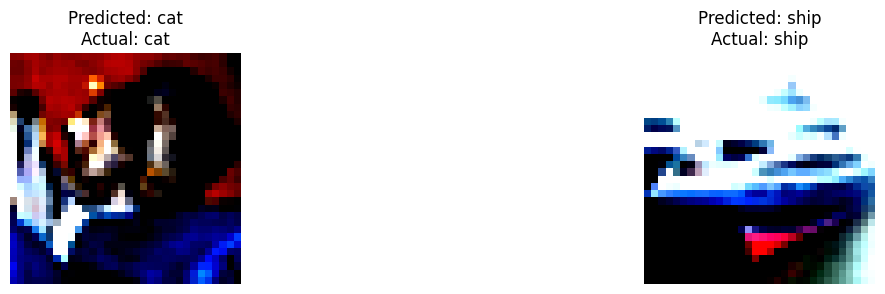

In [15]:
#  CIFAR-10 class names
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck']

# Run the prediction function
visualize_predictions(model, test_loader, cifar10_class_names, num_images=2)


# Analysis and Insights Report

## 1. Overview
This report evaluates the **CIFAR-10 classification task using ResNet-32**, trained across multiple experiments with different hyperparameters. The results were tracked using **Weights & Biases (W&B)** to compare model performance, training efficiency, and hyperparameter effectiveness.

### Key Performance Metrics:
| Run Name         | Optimizer | Learning Rate | Epochs | Test Accuracy | Train Accuracy | Validation Accuracy |
|-----------------|-----------|--------------|--------|--------------|--------------|-------------------|
| floral-surf-6   | SGD       | 0.1          | 85     | **91.62%**   | **98.94%**   | **91.78%**        |
| woven-snowball-5 | SGD      | 0.0005       | 10     | 62.63%       | 62.96%       | 61.86%            |
| different-haze-4 | SGD      | 0.001        | 10     | 69.82%       | 69.63%       | 69.00%            |
| clean-bee-3     | Adam      | 0.0001       | 12     | 72.93%       | 73.03%       | 71.75%            |
| rosy-plant-2    | Adam      | 0.5          | 10     | **10.04%**   | **10.45%**   | **9.97%**         |
| amber-breeze-1  | Adam      | 0.001        | 10     | 76.25%       | 81.39%       | 77.40%            |

---

## 2. Experiment Comparisons Using W&B Dashboards
### Key Observations:
- **Higher learning rates (0.5) caused extreme instability**, as seen in `rosy-plant-2` with a **test accuracy of only 10.04%**.
- **SGD with LR scheduling (`floral-surf-6`) provided the best performance**, achieving **91.62% test accuracy**.
- **Adam optimizer performed well for quick convergence**, but **plateaued around 76.25%** in `amber-breeze-1`.
- **Training with fewer epochs resulted in underperformance**, highlighting the need for longer training runs.

---

## 3. How Hyperparameters Affected Performance

### **Learning Rate (LR) Impact:**
- **Best LR:** **0.1 (with decay at 50 & 75 epochs)** → Enabled **faster convergence and high accuracy**.
- **Worst LR:** **0.5** → Training was highly unstable, causing **extremely high loss and poor test accuracy (10.04%)**.

### **Optimizer Comparison: SGD vs. Adam**
- **SGD (momentum) outperformed Adam in longer runs**.
- **Adam was effective in short runs but plateaued below 80% accuracy**.

### **Effect of Training Epochs:**
- **Less than 20 epochs led to underfitting**, with accuracy **below 70%** in most cases.
- **85 epochs provided strong generalization**, as seen in `floral-surf-6`.

---

## 4. Best Experiment & Why?
### Best Performing Run: `floral-surf-6`
- **Optimizer:** SGD (Momentum = 0.9)
- **Learning Rate:** 0.1 (with decay at 50 & 75 epochs)
- **Epochs:** 85
- **Test Accuracy:** **91.62%**
- **Validation Accuracy:** **91.78%**

### Why was it the best?
- **Effective LR Scheduling:** Allowed controlled optimization and smooth convergence.
- **SGD with momentum stabilized training**, reducing variance in updates.
- **Longer training (85 epochs) ensured strong feature extraction.**

---

## 5. Summary & Final Insights
- **SGD with momentum works best for longer training runs (85+ epochs).**  
- **High learning rates without decay lead to extreme instability.**  
- **Adam optimizer is effective but saturates below 80% accuracy.**  
- **The best accuracy achieved = 91.62% (`floral-surf-6`).**  


